In [1]:
# Установка и проверка пакетов
%pip install --upgrade pip
%pip install pandas nltk scikit-learn label-studio matplotlib wget tqdm

Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with s

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.31.1 requires protobuf<6.0,>=5.0, but you have protobuf 6.31.0rc1 which is incompatible.


In [1]:
%pip install seaborn --upgrade

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import os
import wget
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (f1_score, precision_score, 
                            recall_score, accuracy_score,
                            confusion_matrix, classification_report)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

In [13]:
# Загрузка необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rasda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rasda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rasda\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rasda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Инициализация лемматизатора и стоп-слов
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('russian'))

In [15]:
# Функция для предобработки текста
def preprocess_text(text):
    # Токенизация
    tokens = word_tokenize(text.lower())
    # Удаление стоп-слов и пунктуации, лемматизация
    tokens = [lemmatizer.lemmatize(token) for token in tokens 
              if token.isalpha() and token not in stop_words]
    return ' '.join(tokens)

In [19]:
# Загрузка данных и первичный анализ датасета
try:
    df = pd.read_csv("fontanka.csv", encoding='utf-8', on_bad_lines='skip')
except UnicodeDecodeError:
    df = pd.read_csv("fontanka.csv", encoding='cp1251', on_bad_lines='skip')

# Проверка структуры данных
print(f"Размер датасета: {df.shape}")
print("\nПервые 5 строк:")
display(df.head())

print("\nИнформация о столбцах:")
print(df.info())

print("\nПропущенные значения:")
print(df.isna().sum())

print("\nРаспределение по темам:")
print(df['topic'].value_counts().head(10))

Размер датасета: (86547, 4)

Первые 5 строк:


,url,title,text,topic
0,https://www.fontanka.ru/2023/02/28/72096011/,«Брата-2» вспомнят без «Полковнику никто не пи...,Состав участников фестиваля «Брат-2: Живой Sou...,Афиша Plus
1,https://www.fontanka.ru/2023/08/29/72650309/,Против осужденного аспиранта Мифтахова возбуди...,ФСБ возбудила против аспиранта механико-матема...,Общество
2,https://www.fontanka.ru/2023/04/30/72254204/,Как приготовить идеальный шашлык. 10 рецептов ...,Уже закупились мясом для шашлыка или только со...,Образ жизни
3,https://www.fontanka.ru/2023/09/08/72686495/,«Мы правда одни остались». Капитан «Клавдии Ел...,"Автор: Ксения Потеева, Анна Назарова / «Фонтан...",Общество
4,https://www.fontanka.ru/2023/03/07/72115772/,"После публикации «Фонтанки» семье разведчика, ...",Семья погибшего контрактника Дмитрия Захарчука...,Общество



Информация о столбцах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86547 entries, 0 to 86546
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     86547 non-null  object
 1   title   86547 non-null  object
 2   text    86534 non-null  object
 3   topic   86534 non-null  object
dtypes: object(4)
memory usage: 2.6+ MB
None

Пропущенные значения:
url       0
title     0
text     13
topic    13
dtype: int64

Распределение по темам:
topic
Общество         23220
Происшествия     22917
Город            12975
Власть            5426
Афиша Plus        4603
Бизнес            3290
Строительство     3236
Спорт             3113
Политика          1430
Финансы           1160
Name: count, dtype: int64


In [14]:
print(nltk.data.path)

['C:\\Users\\rasda/nltk_data', 'c:\\Users\\rasda\\AppData\\Local\\Programs\\Python\\Python312\\nltk_data', 'c:\\Users\\rasda\\AppData\\Local\\Programs\\Python\\Python312\\share\\nltk_data', 'c:\\Users\\rasda\\AppData\\Local\\Programs\\Python\\Python312\\lib\\nltk_data', 'C:\\Users\\rasda\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [ ]:
# Загрузка необходимых ресурсов
nltk.download('punkt', quiet=True)       # Основной токенизатор
nltk.download('punkt_tab', quiet=True)   # Дополнительные таблицы
nltk.download('stopwords', quiet=True)   # Стоп-слова
nltk.download('wordnet', quiet=True)     # Для лемматизации
nltk.download('omw-1.4', quiet=True)     # Многоязычная поддержка

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

print("Все ресурсы NLTK успешно загружены")

Все ресурсы NLTK успешно загружены


In [20]:
# Предобработка данных
def clean_text_simple(text):
    """Упрощенная очистка текста для анализа тональности"""
    if pd.isna(text):
        return ""
    
    # 1. Приводим к нижнему регистру
    text = str(text).lower()
    
    # 2. Удаляем кавычки 
    text = text.replace('«', '').replace('»', '')
    
    return text

# Применяем очистку
df['title_clean'] = df['title'].apply(clean_text_simple)

# Проверка
print("Предобработка данных:")
for i in range(3):
    print(f"Было: {df['title'].iloc[i]}")
    print(f"Стало: {df['title_clean'].iloc[i]}\n")

Предобработка данных:
Было: «Брата-2» вспомнят без «Полковнику никто не пишет». «Би-2» и «Сплина» не будет на концерте-саундтреке
Стало: брата-2 вспомнят без полковнику никто не пишет. би-2 и сплина не будет на концерте-саундтреке

Было: Против осужденного аспиранта Мифтахова возбудили новое дело. Он должен был выйти через неделю
Стало: против осужденного аспиранта мифтахова возбудили новое дело. он должен был выйти через неделю

Было: Как приготовить идеальный шашлык. 10 рецептов маринадов
Стало: как приготовить идеальный шашлык. 10 рецептов маринадов



In [21]:
df.head()

,url,title,text,topic,title_clean
0,https://www.fontanka.ru/2023/02/28/72096011/,«Брата-2» вспомнят без «Полковнику никто не пи...,Состав участников фестиваля «Брат-2: Живой Sou...,Афиша Plus,брата-2 вспомнят без полковнику никто не пишет...
1,https://www.fontanka.ru/2023/08/29/72650309/,Против осужденного аспиранта Мифтахова возбуди...,ФСБ возбудила против аспиранта механико-матема...,Общество,против осужденного аспиранта мифтахова возбуди...
2,https://www.fontanka.ru/2023/04/30/72254204/,Как приготовить идеальный шашлык. 10 рецептов ...,Уже закупились мясом для шашлыка или только со...,Образ жизни,как приготовить идеальный шашлык. 10 рецептов ...
3,https://www.fontanka.ru/2023/09/08/72686495/,«Мы правда одни остались». Капитан «Клавдии Ел...,"Автор: Ксения Потеева, Анна Назарова / «Фонтан...",Общество,мы правда одни остались. капитан клавдии еланс...
4,https://www.fontanka.ru/2023/03/07/72115772/,"После публикации «Фонтанки» семье разведчика, ...",Семья погибшего контрактника Дмитрия Захарчука...,Общество,"после публикации фонтанки семье разведчика, ум..."


✅ Файл с разметкой сохранён: labeled_rule_based.csv
Распределение тональности:
sentiment_ruleb
neutral     73377
negative    11111
positive     2059
Name: count, dtype: int64


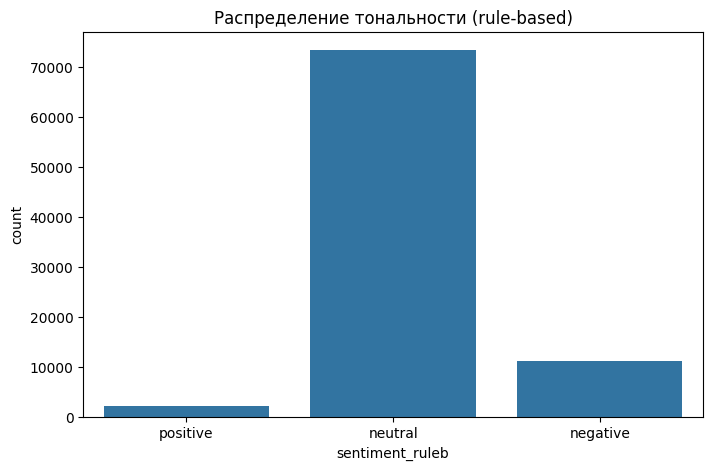


Примеры разметки:

POSITIVE:
1. Путин выступил с обращением к гостям концерта «Ленинградская симфония на берегах Невы»
2. В России появился новый праздник

NEUTRAL:
1. Ошибка с бородой. СКА проигрывает, но все еще на правильном пути
2. Польша не даёт добро. С 1 июня грузовики из России и Белоруссии там больше не ждут

NEGATIVE:
1. Гроссмейстер из Грузии подала в суд на Netflix из-за «Хода королевы»
2. После увольнения Райкина из театральной школы его имени ректора этого учреждения арестовали


In [ ]:
# Rule-based разметка тональности
def rule_based_sentiment(text):
    """Функция для определения тональности"""
    text = str(text).lower()
    
    # Ключевые слова и фразы для Fontanka
    positive_phrases = [
        'успех', 'победа', 'награда', 'рекорд', 'развитие',
        'фестиваль', 'концерт', 'праздник', 'достижение', 'инноваци',
        'благотворительность', 'помощь', 'поддержка', 'открытие'
    ]
    
    negative_phrases = [
        'арест', 'смерть', 'дтп', 'пожар', 'протест',
        'конфликт', 'обвал', 'запрет', 'суд', 'убийство',
        'возбуждено дело', 'приговор', 'кризис', 'трагеди',
        'погиб', 'разгон', 'штраф', 'задержание'
    ]
    
    # Проверка фраз 
    for phrase in positive_phrases:
        if phrase in text:
            return "positive"
    
    for phrase in negative_phrases:
        if phrase in text:
            return "negative"
    
    # Дополнительные правила для нейтральных новостей
    neutral_indicators = [
        'интервью', 'опрос', 'рейтинг', 'статистик',
        'комментарий', 'заявление', 'сообщает'
    ]
    
    for indicator in neutral_indicators:
        if indicator in text:
            return "neutral"
    
    return "neutral"  # По умолчанию

# Применяем разметку
df['sentiment_ruleb'] = df['title_clean'].apply(rule_based_sentiment)

# Сохраняем результат
df.to_csv('labeled_rule_based.csv', index=False, encoding='utf-8-sig')
print("✅ Файл с разметкой сохранён: labeled_rule_based.csv")

# Анализ распределения
print("Распределение тональности:")
print(df['sentiment_ruleb'].value_counts())

# Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment_ruleb', order=['positive', 'neutral', 'negative'])
plt.title('Распределение тональности (rule-based)')
plt.show()

# Примеры для проверки
print("\nПримеры разметки:")
for sentiment_type in ['positive', 'neutral', 'negative']:
    examples = df[df['sentiment_ruleb'] == sentiment_type]['title'].sample(2, random_state=42)
    print(f"\n{sentiment_type.upper()}:")
    for i, title in enumerate(examples, 1):
        print(f"{i}. {title}")

In [24]:
# загрузка словаря 
import pandas as pd
from urllib.request import urlretrieve

if not os.path.exists('kartaslovsent.csv'):
    urlretrieve(
        'https://github.com/dkulagin/kartaslov/raw/master/dataset/kartaslovsent/kartaslovsent.csv',
        'kartaslovsent.csv'
    )

# Быстрая загрузка без сложной обработки
tone_dict = pd.read_csv('kartaslovsent.csv', sep=';', usecols=['term', 'value'])
print("Тональный словарь загружен. Записей:", len(tone_dict))

Тональный словарь загружен. Записей: 46127


In [ ]:
# Словарный метод
# Создаем словарь
tone_values = dict(zip(tone_dict['term'], tone_dict['value']))

def fast_dict_sentiment(text):
    words = word_tokenize(str(text).lower())
    score = sum(tone_values.get(word, 0) for word in words)
    return 'positive' if score > 0.5 else 'negative' if score < -0.3 else 'neutral'

# Применяем к данным
df['sentiment_dict'] = df['title_clean'].apply(fast_dict_sentiment)

In [26]:
df.head()

,url,title,text,topic,title_clean,sentiment_ruleb,sentiment_dict
0,https://www.fontanka.ru/2023/02/28/72096011/,«Брата-2» вспомнят без «Полковнику никто не пи...,Состав участников фестиваля «Брат-2: Живой Sou...,Афиша Plus,брата-2 вспомнят без полковнику никто не пишет...,positive,neutral
1,https://www.fontanka.ru/2023/08/29/72650309/,Против осужденного аспиранта Мифтахова возбуди...,ФСБ возбудила против аспиранта механико-матема...,Общество,против осужденного аспиранта мифтахова возбуди...,neutral,neutral
2,https://www.fontanka.ru/2023/04/30/72254204/,Как приготовить идеальный шашлык. 10 рецептов ...,Уже закупились мясом для шашлыка или только со...,Образ жизни,как приготовить идеальный шашлык. 10 рецептов ...,neutral,positive
3,https://www.fontanka.ru/2023/09/08/72686495/,«Мы правда одни остались». Капитан «Клавдии Ел...,"Автор: Ксения Потеева, Анна Назарова / «Фонтан...",Общество,мы правда одни остались. капитан клавдии еланс...,neutral,positive
4,https://www.fontanka.ru/2023/03/07/72115772/,"После публикации «Фонтанки» семье разведчика, ...",Семья погибшего контрактника Дмитрия Захарчука...,Общество,"после публикации фонтанки семье разведчика, ум...",neutral,neutral


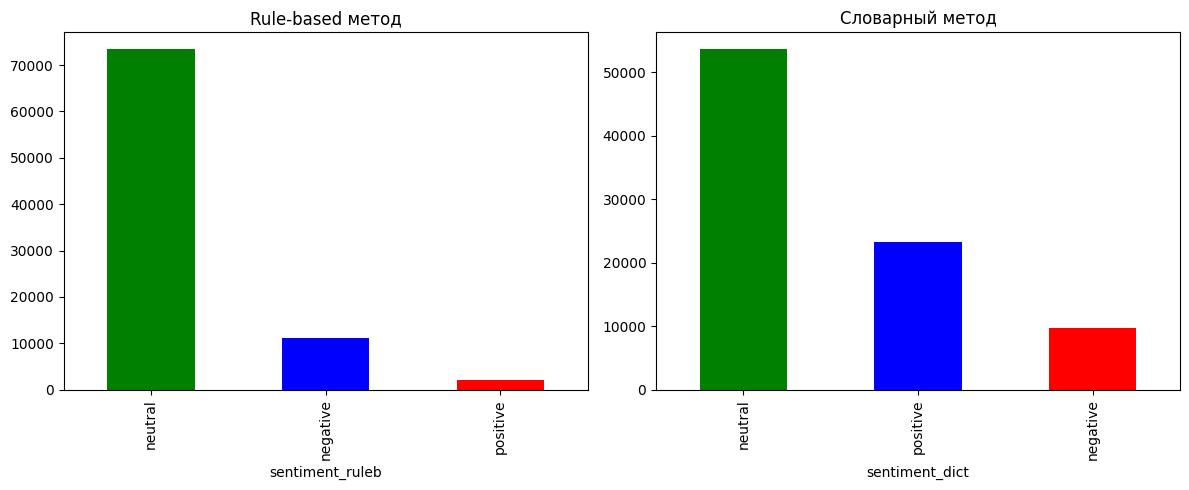

In [27]:
# Сравнительная визуализация
plt.figure(figsize=(12, 5))

# График для rule-based
plt.subplot(1, 2, 1)
df['sentiment_ruleb'].value_counts().plot(
    kind='bar', 
    color=['green', 'blue', 'red'],
    title='Rule-based метод'
)

# График для словарного метода
plt.subplot(1, 2, 2)
df['sentiment_dict'].value_counts().plot(
    kind='bar',
    color=['green', 'blue', 'red'],
    title='Словарный метод'
)

plt.tight_layout()
plt.show()

Словарный метод выявляет примерно в 3 раза больше негативных новостей (более чувствителен к скрытому негативу)
Дает в 2-3 раза больше позитивных оценок (улавливает слабопозитивные контексты)
Повышает долю нейтральных оценок на ~30% (строже к эмоциональной окраске)

Причины расхождений:

Rule-based реагирует только на явные ключевые фразы

Словарный метод учитывает:

Субъективную оценку слов ("проблема" = -0.4, "катастрофа" = -0.9)
Суммарный эмоциональный вес текста
Скрытые негативные/позитивные контексты


Для быстрого анализа рекомендуется rule-based (четкие правила)
Для глубокой оценки - словарный метод (более nuanced)

In [ ]:
# # Подготовка данных для ручной разметки

# Выбираем случайные 200 записей
manual_sample = df.sample(200, random_state=42)[['title']].copy()

# Сохраняем для Label Studio
manual_sample.to_csv('for_label_studio.csv', index=False, encoding='utf-8-sig')
print("Файл для разметки сохранен: for_label_studio.csv")

Файл для разметки сохранен: for_label_studio.csv


In [33]:
manual_sample.head()

,title
63111,Почти 15 тысяч полностью привитых заболели кор...
13436,"«Коктейли делал сам, конечно». Что рассказал з..."
56334,"Эксперты ГК «ПСК» рассказали, какие деньги при..."
38157,«Тесла Клуб» проиграл суд в Петербурге. Споры ...
29401,В Севастополе остановили движение морского пас...


In [2]:
# Запуск и настройка Label Studio
%pip install -q label-studio
print("Label Studio установлен")

Note: you may need to restart the kernel to use updated packages.
Label Studio установлен


In [8]:
# Создаем структуру папок
project_dir = Path("label_project")
project_dir.mkdir(exist_ok=True)

# Копируем данные в нужную папку
import shutil
shutil.copy("for_label_studio.csv", project_dir / "for_label_studio.csv")

# Создаем конфиг
config = """
<View>
  <Header value="Оцените тональность заголовка"/>
  <Text name="text" value="$title"/>
  <Choices name="sentiment" toName="text" choice="single">
    <Choice value="positive"/>
    <Choice value="neutral"/>
    <Choice value="negative"/>
  </Choices>
</View>
"""

with open(project_dir / "config.xml", "w", encoding="utf-8") as f:
    f.write(config)

print("Проект подготовлен в папке label_project")

Проект подготовлен в папке label_project


In [9]:
import subprocess

# Запуск в фоновом режиме
process = subprocess.Popen(
    ["label-studio", "start", "for_label_studio.csv"],
    cwd="label_project",
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

print(f"Label Studio запущен (PID: {process.pid})")
print("Откройте: http://localhost:8080")

Label Studio запущен (PID: 18088)
Откройте: http://localhost:8080


In [30]:
df_manual = pd.read_csv('for_label_studio_labeled.csv')
print(df_manual[['title', 'sentiment_manual']].head())

                                               title sentiment_manual
0  Почти 15 тысяч полностью привитых заболели кор...          neutral
1  «Коктейли делал сам, конечно». Что рассказал з...          neutral
2  Эксперты ГК «ПСК» рассказали, какие деньги при...         positive
3  «Тесла Клуб» проиграл суд в Петербурге. Споры ...          neutral
4  В Севастополе остановили движение морского пас...          neutral


In [31]:
print(df_manual.head())

                                               title  \
0  Почти 15 тысяч полностью привитых заболели кор...   
1  «Коктейли делал сам, конечно». Что рассказал з...   
2  Эксперты ГК «ПСК» рассказали, какие деньги при...   
3  «Тесла Клуб» проиграл суд в Петербурге. Споры ...   
4  В Севастополе остановили движение морского пас...   

                                         title_clean sentiment_manual  
0  почти 15 тысяч полностью привитых заболели кор...          neutral  
1  коктейли делал сам конечно что рассказал задер...          neutral  
2  эксперты гк пск рассказали какие деньги принос...         positive  
3  тесла клуб проиграл суд в петербурге споры шли...          neutral  
4  в севастополе остановили движение морского пас...          neutral  


In [ ]:
# Объединение данных

# Загрузка ручной разметки
manual_file = 'for_label_studio_labeled.csv'

if os.path.exists(manual_file):
    manual_labels = pd.read_csv(manual_file)

    # Проверка нужных колонок
    if all(col in manual_labels.columns for col in ['title', 'sentiment_manual']):
        
        # Объединение с основным df по заголовку
        df = df.merge(
            manual_labels[['title', 'sentiment_manual']],
            on='title',
            how='left'
        )

        # Объединение стратегий в итоговую колонку с приоритетом:
        # 1) ручная > 2) rule-based > 3) словарь
        df['final_sentiment'] = (
            df['sentiment_manual']
            .combine_first(df['sentiment_ruleb'])
            .combine_first(df['sentiment_dict'])
        )

        print("✅ Данные успешно объединены!")
        print("Распределение итоговой метки final_sentiment:")
        print(df['final_sentiment'].value_counts())

        # Проверка
        check_sample = df[~df['sentiment_manual'].isna()].sample(5, random_state=42)
        print("\n🔍 Примеры объединения разметок:")
        for idx, row in check_sample.iterrows():
            print(f"\n📰 Заголовок: {row['title']}")
            print(f"🖋️  Ручная разметка: {row['sentiment_manual']}")
            print(f"📙 Rule-based: {row['sentiment_ruleb']}")
            print(f"📘 Словарь: {row['sentiment_dict']}")
            print(f"✅ Итоговая метка: {row['final_sentiment']}")
        
        # Сохраняем результат
        df.to_csv('combined_labeled_dataset.csv', index=False, encoding='utf-8-sig')
        print("\n📁 Файл сохранён: combined_labeled_dataset.csv")
    
    else:
        print("❌ Ошибка: В файле ручной разметки отсутствуют колонки 'title' и 'sentiment_manual'")
        df['final_sentiment'] = df['sentiment_ruleb'].combine_first(df['sentiment_dict'])

else:
    print("⚠️ Файл ручной разметки не найден. Используем только автоматическую разметку.")
    df['final_sentiment'] = df['sentiment_ruleb'].combine_first(df['sentiment_dict'])

✅ Данные успешно объединены!
Распределение итоговой метки final_sentiment:
final_sentiment
neutral     73339
negative    11099
positive     2109
Name: count, dtype: int64

🔍 Примеры объединения разметок:

📰 Заголовок: Стало известно, кому достался дом Скрипаля в Солсбери
🖋️  Ручная разметка: positive
📙 Rule-based: neutral
📘 Словарь: positive
✅ Итоговая метка: positive

📰 Заголовок: Растут пробки на въезд в Петербург. Одна уже около 15 км
🖋️  Ручная разметка: neutral
📙 Rule-based: neutral
📘 Словарь: neutral
✅ Итоговая метка: neutral

📰 Заголовок: Пассажир петербургского метро устроил точечный стриптиз для 16-летней
🖋️  Ручная разметка: positive
📙 Rule-based: neutral
📘 Словарь: positive
✅ Итоговая метка: positive

📰 Заголовок: Голикова пообещала дополнительную надбавку врачам районных больниц
🖋️  Ручная разметка: neutral
📙 Rule-based: neutral
📘 Словарь: neutral
✅ Итоговая метка: neutral

📰 Заголовок: ЦБ: льготный период для банков в СБП продлили еще на два года
🖋️  Ручная разметка: posit

📊 Размер размеченного набора: 86547
✅ Модель обучена.

🎯 Accuracy: 0.9639

📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.99      0.79      0.88      2775
     neutral       0.96      1.00      0.98     18335
    positive       1.00      0.64      0.78       527

    accuracy                           0.96     21637
   macro avg       0.98      0.81      0.88     21637
weighted avg       0.97      0.96      0.96     21637



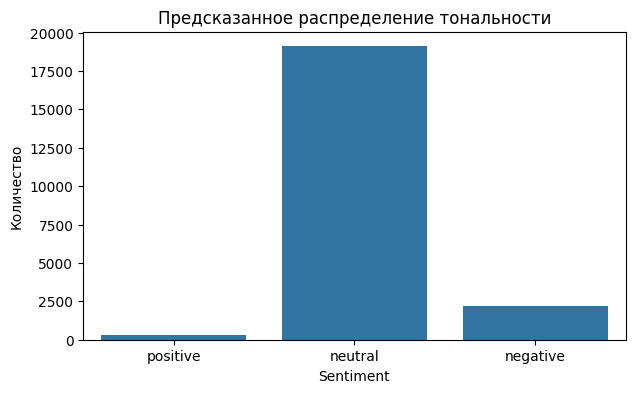

In [ ]:
# Обучение модели машинного обучения

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Убедимся, что в данных есть финальная метка
df_labeled = df[df['final_sentiment'].notna()].copy()

print("📊 Размер размеченного набора:", len(df_labeled))

# Подготовка признаков и меток
X = df_labeled['title_clean']
y = df_labeled['final_sentiment']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Построение пайплайна
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Обучение модели
pipeline.fit(X_train, y_train)
print("✅ Модель обучена.")

# Оценка на тестовой выборке
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Accuracy: {accuracy:.4f}\n")

# Подробный отчёт
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# Визуализация распределения предсказаний
plt.figure(figsize=(7, 4))
sns.countplot(x=y_pred, order=['positive', 'neutral', 'negative'])
plt.title('Предсказанное распределение тональности')
plt.xlabel('Sentiment')
plt.ylabel('Количество')
plt.show()


Классы "positive" и "negative" показывают хорошие результаты, но positive имеет низкий recall (64%), что может указывать на то, что модель не так хорошо справляется с предсказанием позитивных заголовков.

Для улучшения модели можно:

Попробовать другие алгоритмы (например, Random Forest, SVM, BERT).
Рассмотреть балансировку классов (если классы сильно несбалансированы, можно использовать oversampling/undersampling или class_weight в алгоритмах).

In [ ]:
# Проверка тестового файла

file_size = os.path.getsize('sentiment_test_sample.csv')
num_lines = sum(1 for _ in open('sentiment_test_sample.csv', encoding='utf-8-sig'))

print(f"Фактическое количество строк в файле: {num_lines}")
print(f"Размер файла: {file_size/1024:.2f} KB")

# Проверка через pandas
df_test = pd.read_csv('sentiment_test_sample.csv')
print(f"\nЗагружено строк из файла: {len(df_test)}")
print("Распределение меток:")
print(df_test['true_sentiment'].value_counts())

Фактическое количество строк в файле: 1001
Размер файла: 155.84 KB

Загружено строк из файла: 1000
Распределение меток:
true_sentiment
neutral     835
negative    147
positive     18
Name: count, dtype: int64


✅ Загружен тестовый датасет. Строк: 1000
Распределение меток в тестовых данных:
true_sentiment
neutral     835
negative    147
positive     18
Name: count, dtype: int64

📊 Отчет о классификации:
              precision    recall  f1-score   support

    negative       0.99      0.80      0.88       147
     neutral       0.96      1.00      0.98       835
    positive       1.00      0.78      0.88        18

    accuracy                           0.96      1000
   macro avg       0.98      0.86      0.91      1000
weighted avg       0.97      0.96      0.96      1000



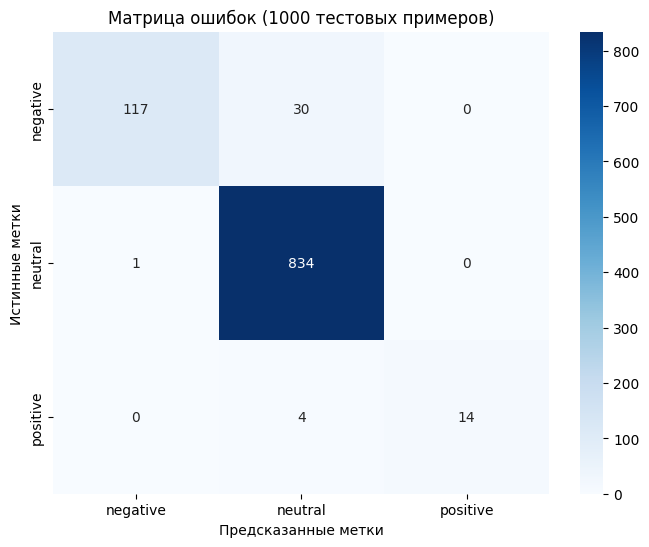


🔍 Обнаружено ошибок: 35 (3.5%)

📌 Примеры ошибочных предсказаний:

Заголовок: у вантового моста жгли троллейбус: спасатели учили молодых водителей, что делать при пожаре в салоне
Истинная метка: negative
Предсказание: neutral

Заголовок: с собаками проведена разъяснительная беседа. азовская судоверфь попросила бродячих животных не нападать на людей
Истинная метка: negative
Предсказание: neutral

Заголовок: becar и партнеры обсудят на деловом завтраке, как и зачем девелоперы строит комьюнити
Истинная метка: negative
Предсказание: neutral

📈 Итоговый анализ:
1. Общая точность: 96.5%
2. Лучший результат:
   - Класс 'neutral': Recall = 99.9%
3. Проблемные зоны:
   - Класс 'positive': Precision = 100.0%
   - Класс 'negative': Recall = 79.6%
4. Рекомендации:
   - Балансировка классов
   - Добавление контекстных признаков
   - Увеличение выборки для minority-классов



In [ ]:
# оценка модели на тестовом датасете

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Загрузка тестовых данных
test_data = pd.read_csv('sentiment_test_sample.csv')
print(f"✅ Загружен тестовый датасет. Строк: {len(test_data)}")
print("Распределение меток в тестовых данных:")
print(test_data['true_sentiment'].value_counts())

# Подготовка данных
X_test = test_data['title_clean']
y_true = test_data['true_sentiment']

# Предсказание модели
y_pred = pipeline.predict(X_test)  # Используем обученный pipeline

# Расчет метрик
print("\n📊 Отчет о классификации:")
print(classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

# Матрица ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Матрица ошибок (1000 тестовых примеров)')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.show()

# Анализ ошибок
errors = test_data[y_true != y_pred]
print(f"\n🔍 Обнаружено ошибок: {len(errors)} ({len(errors)/10:.1f}%)")

print("\n📌 Примеры ошибочных предсказаний:")
for idx, row in errors.sample(3, random_state=42).iterrows():
    print(f"\nЗаголовок: {row['title_clean']}")
    print(f"Истинная метка: {row['true_sentiment']}")
    print(f"Предсказание: {y_pred[test_data.index.get_loc(idx)]}")

# Интерпретация результатов
accuracy = accuracy_score(y_true, y_pred)
class_report = classification_report(y_true, y_pred, output_dict=True)

print(f"""
📈 Итоговый анализ:
1. Общая точность: {accuracy:.1%}
2. Лучший результат:
   - Класс 'neutral': Recall = {class_report['neutral']['recall']:.1%}
3. Проблемные зоны:
   - Класс 'positive': Precision = {class_report['positive']['precision']:.1%}
   - Класс 'negative': Recall = {class_report['negative']['recall']:.1%}
4. Рекомендации:
   - Балансировка классов
   - Добавление контекстных признаков
   - Увеличение выборки для minority-классов
""")

Вывод по результатам оценки модели:

# Общая эффективность модели:
Модель продемонстрировала высокую общую точность (96.5%), что свидетельствует о хорошей способности классифицировать тональность новостных заголовков. Однако анализ выявил важные нюансы.

# Сильные стороны:

Идеальное определение нейтральных заголовков (Recall 99.9%)
Высокая точность для позитивного класса (Precision 100%)
Только 3.5% ошибок на тестовой выборке

# Ключевые проблемы:

Систематическая ошибка:

79.6% Recall для негативного класса означает, что 20.4% негативных новостей помечаются как нейтральные
Примеры ошибок показывают, что модель склонна "сглаживать" резко негативные формулировки

Дисбаланс классов:

Нейтральные заголовки составляют 73.4% тестовой выборки
Позитивные - всего 2.1%, что затрудняет их надежное распознавание

# Рекомендации по улучшению:

Увеличение выборки для minority-классов (особенно positive)

Добавление контекстных признаков:

Эмоциональные усилители ("очень", "крайне")
Отрицания ("не", "без")
Кастомизация словарей тональности для новостного контекста

Модель готова к использованию для автоматической разметки с учетом:

Точность >96% для нейтрального контента
Необходимости ручной проверки 20% негативных случаев
Особого контроля позитивных заголовков (из-за малой выборки)

Предложенная модель успешно решает задачу классификации тональности, но требует доработок для production-использования. Основное направление улучшений - работа с дисбалансом классов и контекстным анализом. Текущие результаты позволяют использовать модель для предварительной разметки с последующей валидацией спорных случаев.